# Root Cause Discovery + Lasso

Here for a known "root cause gene", lets run a Lasso regression to filter down the number of features, before running Root Cause Discovery algorithm

+ After processing, we obtained 2 datasets
    1. "Interventional data": there are 32 samples for which we have ground truth data. Each row is a gene and each column is a sample. 
    2. "observational data": these are a few hundred samples for which we did not do any intervention. Each row is a gene and each column is a sample.
+ The main idea is that an intervention supposedly caused a disturbance in gene expression, so we can compare the data of intervention to baseline (i.e. observational data), and try to which gene is most differentially expressed

In [12]:
using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

using Plots
gr(fmt=:png)

# import RootCauseDiscovery.zscore
# import RootCauseDiscovery.compute_permutations
# import RootCauseDiscovery.root_cause_discovery
# import RootCauseDiscovery.find_largest
# import RootCauseDiscovery.find_second_largest

# using Statistics
# import StatsBase.cov2cor
# using GLMNet
# using CovarianceEstimation
# using LinearAlgebra
# using Plots
# gr(fmt=:png)
# include("/home/users/bbchu/RootCauseDiscovery/utilities.jl")

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, 
        total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

"""
Given a patient, we compute its Z-score rank, and then try to refine
its rank via the RCD method. Note: if the root cause was not used as
the response in lasso regression, its refined rank will be `Inf`
"""
function refine_z_score_rank(
        jld2_file::String,
        patient_id::AbstractString,
        ground_truth::DataFrame,
        Xobs::AbstractMatrix,
        Xint::AbstractMatrix; #cv or largest_support
        max_acceptable_zscore = 1.5,
        verbose::Bool=true
    )
#     jld2_file = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/$(lasso_method)/$(patient_id).jld2"
    results = JLD2.load(jld2_file, "results")
    y_indices = JLD2.load(jld2_file, "y_indices")

    # compute z scores
    Xint_sample = Xint[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), :]
    z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

    # compute root cause index
    root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
    if root_cause_idx ∉ y_indices
        verbose && println("The root cause was not chosen as a y for lasso")
        return Inf # return Inf when the root cause idx was not chosen as a y for lasso
    end

    # other needed quantities
    root_cause_zscore = z[root_cause_idx]
    root_cause_zscore_rank = count(x -> x > root_cause_zscore, z[y_indices])
    row_of_rootcause_in_result = findfirst(x -> x == root_cause_idx, y_indices)

    # for each gene w/ z score > 1.5, check its permutation table
    # to see if desired pattern exist
    matched = falses(length(results)) # length(matched) == length(results) == length(y_indices) 
    for (i, result) in enumerate(results)
        row = findlast(x -> x > max_acceptable_zscore, result[:, 6])
        if !isnothing(row)
            if result[row, 5] == result[row, 7]
                matched[i] = true
            end
        end
    end

    # calculate the refined rank for root cause
    root_cause_matched = matched[row_of_rootcause_in_result]
    if root_cause_matched
        # for all matching patterns, count how many have z scores
        # larger than the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) && (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    else
        # if root cause index did not have desired matching pattern,
        # then if there's a matched variable, or the variable has larger Z score,
        # the variable will be ranked before the root cause
        counter = 0
        for (i, yi) in enumerate(y_indices)
            if (matched[i] == true) || (z[yi] > root_cause_zscore)
                counter += 1
            end
        end
        rk = counter
    end
    return rk
end

function make_plot(
        Z_score_rank::AbstractVector, 
        RCD_rank::AbstractVector, 
        patient_name::AbstractVector;
        plot1_ymax = 5500,
        plot2_ymin = -2500,
        plot2_ymax = 2500
    )
    # sort by diff in Z scores
    Z_score_diff = Z_score_rank - RCD_rank
    perm = sortperm(Z_score_diff)

    #
    # plot 1
    #
    plt1 = scatter(
        1:length(patient_name), 
        Z_score_rank[perm], 
        ylabel="rank", 
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        label = "Original z-score rank",
        title = "Root cause rank (Z-score vs Cholesky score)",
        legend=:top,
        dpi=300,
        ylim=(0, plot1_ymax)
    )
    scatter!(plt1, 1:length(patient_name), RCD_rank[perm], label="Refined Z-score rank")

    #
    # plot 2
    #
    palettes = theme_palette(:auto)
    my_colors = []
    for i in eachindex(Z_score_diff)
        if isinf(Z_score_diff[i])
            push!(my_colors, :black)
            Z_score_diff[i] = plot2_ymin
        elseif Z_score_diff[i] > 0
            push!(my_colors, palettes[1])
        elseif Z_score_diff[i] == 0
            push!(my_colors, palettes[3])
        else
            push!(my_colors, palettes[2])
        end
    end

    # make plot
    plt2 = scatter(
        1:length(patient_name_success), 
        Z_score_diff[perm],
        title="Original Z score rank - refined Z score rank", 
        ylabel="Rank difference",
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        ylim=(plot2_ymin, plot2_ymax),
        label = nothing,
        legend=:outerbottom,
        color=my_colors[perm],
        dpi=300,
    )
    hline!(plt2, [0], color=:black, linestyle=:dash, label=nothing)

    #
    # combine plots
    #
    return plot(plt1, plt2, layout = (2, 1), size=(800, 600))
end

make_plot (generic function with 1 method)

## Read processed data
First, read in data and log (base 2) transform them

In [9]:
# low_count = 5
# threshold = 0.05

# default
low_count = 10
threshold = 0.2

# read processed data
dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/data"
isdir(dir) || mkpath(dir)
trainsform_int_file = joinpath(dir, "transform_int")
transform_obs_file = joinpath(dir, "transform_obs")
ground_truth_file = joinpath(dir, "ground_truth")

if !(isfile(trainsform_int_file) && isfile(transform_obs_file) && isfile(ground_truth_file))
    # process raw data & save
    transform_int, transform_obs, ground_truth = QC_gene_expression_data(;
        low_count = low_count, threshold = threshold)
    CSV.write(trainsform_int_file, transform_int)
    CSV.write(transform_obs_file, transform_obs)
    CSV.write(ground_truth_file, ground_truth)
else
    transform_int = CSV.read(trainsform_int_file, DataFrame)
    transform_obs = CSV.read(transform_obs_file, DataFrame)
    ground_truth = CSV.read(ground_truth_file, DataFrame)
end

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

32×18786 transpose(::Matrix{Float64}) with eltype Float64:
 7.15963  7.52113  6.15452  5.75581  …  2.66477  1.72031   4.2403   5.86117
 7.27295  7.47476  5.71744  6.76805     3.86115  2.25171   3.82032  6.11873
 7.11711  7.69937  6.29269  5.83369     3.16361  1.24669   4.55723  6.01907
 7.32262  7.5701   5.62695  5.65956     3.26167  1.68122   4.18966  5.79909
 7.30718  7.64175  5.94946  5.70915     2.89075  2.19761   4.37236  6.22296
 7.955    7.62097  6.30596  5.60628  …  2.37088  0.579117  4.82761  5.77485
 6.8234   7.12233  5.8819   5.75597     3.24978  1.76171   4.57797  5.41422
 7.39594  6.96646  5.92392  5.21208     3.13891  2.3404    4.37728  5.50915
 6.96517  7.23575  5.89276  6.66992     2.43846  2.67962   4.1837   5.95136
 6.67546  7.15309  5.75577  6.28015     2.37818  2.0215    4.20273  5.73855
 7.23575  7.47955  5.86169  6.36955  …  2.88065  2.64703   4.1685   6.367
 7.23278  7.42347  6.16229  6.4314      1.67045  2.36359   4.39737  5.86872
 6.96603  7.20675  6.33847  4.9

## Test run Root Cause Discovery

In [3]:
# parameters for current run
patient_id = "R62943"
y_idx_z_threshold = 10.0
method = "largest_support"

# run main alg
Random.seed!(2024)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=2
);

# save result in jld2 format
# outfile = "/scratch/users/bbchu/RootCauseDiscovery/result_3.18.2024/$(patient_id).jld2"
# save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

Trying 4 y_idx
Lasso found 362 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


Lasso found 361 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Lasso found 392 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


Lasso found 368 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


204.909245 seconds (18.00 M allocations: 82.330 GiB, 0.98% gc time, 9.11% compilation time)


## Test run Root Cause Discovery 

This assumes root cause is treated as response

In [11]:
# lasso 
Random.seed!(2024)
patient_id = "R59185" #  "R80346", "R58859", "R28774", "R62943", "R20754", "R36605", "R60537" works
root_cause_idx = ground_truth[
    findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
method = "largest_support"
Xobs_new, Xint_sample_new, root_cause_idx_new = 
    RootCauseDiscovery.reduce_genes(patient_id, 
    root_cause_idx, Xobs, Xint, ground_truth, method)

# run main alg
@time result = RootCauseDiscovery.root_cause_discovery_reduced_dimensional(
    Xobs_new, Xint_sample_new, nshuffles=10)
result

Lasso found 298 non-zero entries


Progress: 100%|█████████████████████████████████████████| Time: 0:03:19


200.866207 seconds (9.03 M allocations: 90.328 GiB, 4.81% gc time, 3.58% compilation time)


19730×7 Matrix{Float64}:
 177.205  177.202    0.00297885  1.68104e-5    59.0   0.525524  299.0
 210.854  210.849    0.00473616  2.24623e-5   218.0  12.1319    299.0
 195.045  195.038    0.00683608  3.505e-5      98.0   6.46742   299.0
 166.767  166.758    0.00884806  5.30591e-5   264.0   0.437162  299.0
 196.012  196.0      0.0118448   6.04329e-5    25.0   0.506221  299.0
 188.389  188.371    0.0178189   9.45946e-5    42.0   7.05257   299.0
 197.483  197.462    0.0213675   0.000108211  107.0   0.149818  299.0
 157.228  157.208    0.0193019   0.000122779   59.0   0.525524  299.0
 176.192  176.167    0.0251851   0.000142962  124.0   4.71349   299.0
 169.87   169.846    0.0248827   0.000146502  124.0   4.71349   299.0
 242.328  242.279    0.0484101   0.000199811  148.0   4.82665   299.0
 199.349  199.306    0.0426088   0.000213785   14.0   5.84164   299.0
 142.272  142.239    0.032649    0.000229535  135.0   0.465891  299.0
   ⋮                                                  ⋮         


## Submit jobs

In [ ]:
# put this in script /scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/high_dimension_RCD.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using LinearAlgebra
BLAS.set_num_threads(1)

# inputs to the script
patient_id = ARGS[1]
y_idx_z_threshold = parse(Float64, ARGS[2])
method = ARGS[3] # "cv" or "largest_support"
outfile = ARGS[4]

# process raw data
transform_int, transform_obs, ground_truth = 
    QC_gene_expression_data(low_count = 5, threshold = 0.05);

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

# run main alg
Random.seed!(2024)
@time results, y_indices = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=10
);

# save result
save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

# to load later, do:
# using JLD2
# results = load("R58859.jld2", "results")
# y_indices = load("R58859.jld2", "y_indices")


### Submit jobs for each patient

20 runs take ~300 sec, so if a patient requires 4000 tries, it'll take ~16.6h

In [13]:
dirs = [
    "/scratch/users/bbchu/RootCauseDiscovery/result_3.29.2024",
    "/scratch/users/bbchu/RootCauseDiscovery/result_3.30.2024",
    "/scratch/users/bbchu/RootCauseDiscovery/result_3.31.2024",
    "/scratch/users/bbchu/RootCauseDiscovery/result_4.1.2024",
    "/scratch/users/bbchu/RootCauseDiscovery/result_4.2.2024",
]

for dir in dirs
    joblog_dir = joinpath(dir, "joblogs")
    julia_exe = joinpath(dir, "high_dimension_RCD.jl")
    y_idx_z_threshold = 1.5
    patient_name = ground_truth[!, "Patient ID"]
    for method in ["largest_support"]
        for patient in patient_name
            outfile = joinpath(dir, method, "$(patient).jld2")
            if !isfile(outfile)
                cmd = "julia -t 24 $julia_exe $patient $y_idx_z_threshold $method $outfile"
                submit(cmd, 24, 64, joblog_dir, jobname=patient)
            end
        end
    end
end

Submitted batch job 44180596

Submitted batch job 44180598

Submitted batch job 44180600

Submitted batch job 44180602

Submitted batch job 44180604

Submitted batch job 44180606

Submitted batch job 44180608

Submitted batch job 44180610

Submitted batch job 44180612

Submitted batch job 44180614

Submitted batch job 44180615

Submitted batch job 44180617

Submitted batch job 44180619

Submitted batch job 44180621

Submitted batch job 44180622

Submitted batch job 44180624

Submitted batch job 44180626

Submitted batch job 44180629

Submitted batch job 44180631

Submitted batch job 44180633

Submitted batch job 44180634

Submitted batch job 44180636

Submitted batch job 44180638

Submitted batch job 44180641

Submitted batch job 44180643

Submitted batch job 44180645

Submitted batch job 44180647

Submitted batch job 44180649

Submitted batch job 44180651

Submitted batch job 44180652

Submitted batch job 44180654

Submitted batch job 44180656

Submitted batch job 44180657

Submitted 

## Inspect result

Check for 1 patient when the root cause is used as response in Lasso

For bad result, check the result when treating the RC as response: 1. did we use standard covariance estimator; 2. take a look at the result 

In [6]:
using JLD2
patient_id = "R59185" # "R80346"
dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support"
results = load(joinpath(dir, "$patient_id.jld2"), "results")
y_indices = load(joinpath(dir, "$patient_id.jld2"), "y_indices")

# compute Z scores for this patient
i = findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"])
Xint_sample = Xint[i, :]
z = RootCauseDiscovery.zscore(Xobs, Xint_sample') |> vec

# check our result one by one, starting with largest z score
# perm = sortperm(z, rev=true)
# for zi in z[perm]
#     result = results[findfirst(x -> x == zi, z[y_indices])]
# end

# check root cause index results
root_cause_idx = ground_truth[findfirst(x -> x == patient_id, ground_truth[!, "Patient ID"]), end]
root_cause_zscore = z[root_cause_idx]
@show root_cause_zscore
result = results[findfirst(x -> x == root_cause_idx, y_indices)]

root_cause_zscore = 4.074037437937148


19730×7 Matrix{Float64}:
 187.05   187.05      0.000262596  1.40388e-6    70.0  11.9261    299.0
 221.417  221.412     0.00502335   2.26878e-5   190.0   4.92881   299.0
 188.024  188.019     0.00561232   2.98498e-5    61.0   5.44354   299.0
 216.257  216.249     0.00741127   3.42719e-5   107.0   0.149818  299.0
 195.858  195.85      0.00779773   3.98149e-5    63.0   1.08728   299.0
 219.065  219.056     0.00884922   4.0397e-5     61.0   5.44354   299.0
 186.98   186.971     0.00927791   4.96222e-5   198.0   1.85353   299.0
 247.365  247.352     0.0130287    5.26728e-5    91.0   2.59965   299.0
 152.983  152.973     0.0107354    7.01787e-5    39.0   0.89276   299.0
 159.458  159.444     0.0139878    8.77283e-5    62.0   8.34699   299.0
 192.447  192.43      0.0171463    8.91042e-5   185.0   0.117593  299.0
 173.249  173.233     0.016092     9.28923e-5   129.0   2.32902   299.0
 195.887  195.865     0.0222309    0.000113501  126.0   2.76529   299.0
   ⋮                                   

# Refine rank for all patients

### 3.28.2024

+ low_count = 5
+ threshold = 0.05

In [5]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress:  16%|██████▍                                  |  ETA: 0:03:39

ArgumentError(

Progress:  19%|███████▊                                 |  ETA: 0:02:56

"No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support/R15264.jld2")


Progress:  44%|██████████████████                       |  ETA: 0:02:12

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support/R28774.jld2")


Progress:  59%|████████████████████████▍                |  ETA: 0:01:23

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support/R46723.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support/R58859.jld2")


Progress: 100%|█████████████████████████████████████████| Time: 0:03:08


ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/result_3.28.2024/largest_support/R70961.jld2")
df = 27×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        985.0                 404.0
   2 │ R98254                       2948.0                4371.0
   3 │ R86287                      17420.0                 Inf
   4 │ R89912                        107.0                  48.0
   5 │ R19100                          0.0                   0.0
   6 │ R36605                        366.0                 163.0
   7 │ R61100                          5.0                   1.0
   8 │ R77611                         13.0                   2.0
   9 │ R16472                          0.0                   0.0
  10 │ R51757                         31.0                  10.0
  11 │ R80346    

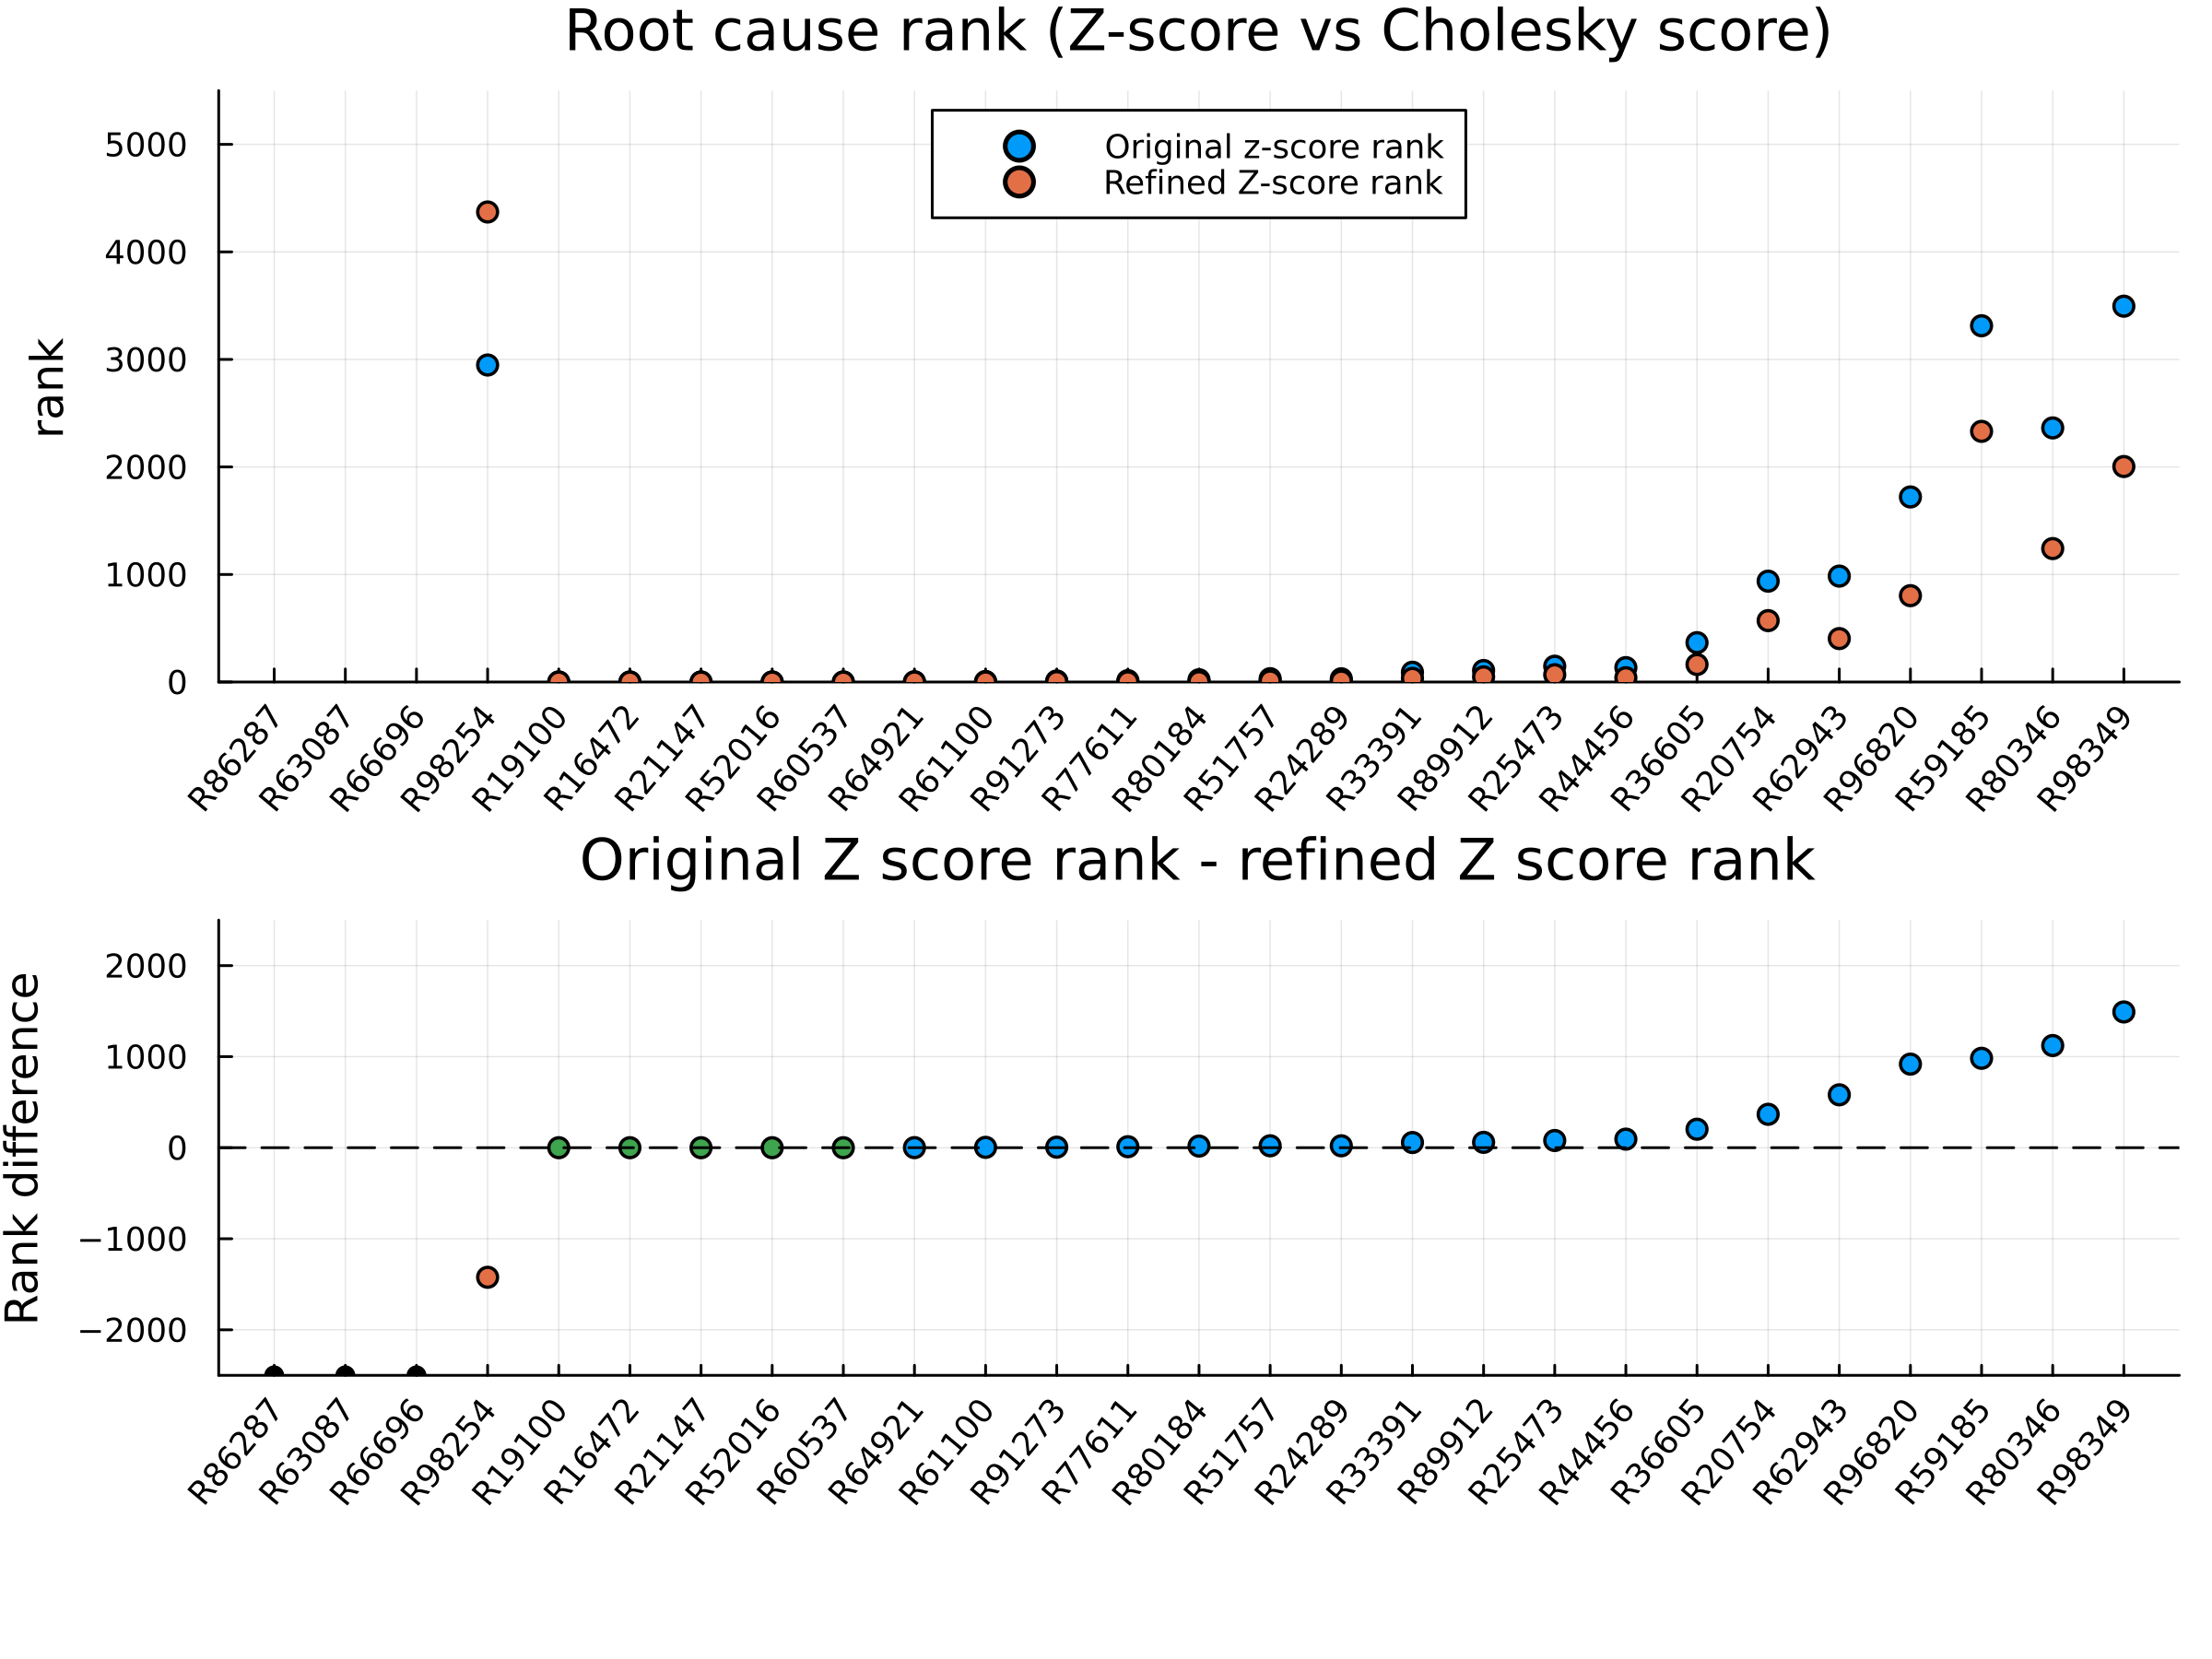

In [8]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2500, plot2_ymax = 2500
)
plot(plt)

### 3.25.2024

+ `/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024`

In [10]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.25.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = refine_z_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


df = 32×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        668.0                 376.0
   2 │ R98254                       1908.0                1266.0
   3 │ R86287                      13749.0                 Inf
   4 │ R89912                         51.0                  30.0
   5 │ R19100                          0.0                   0.0
   6 │ R15264                          0.0                   0.0
   7 │ R36605                        251.0                 134.0
   8 │ R61100                          1.0                   0.0
   9 │ R77611                          4.0                   2.0
  10 │ R16472                          0.0                   0.0
  11 │ R51757                         17.0                   8.0
  12 │ R80346                       1430.0                 837.0
  13 │ R20754      

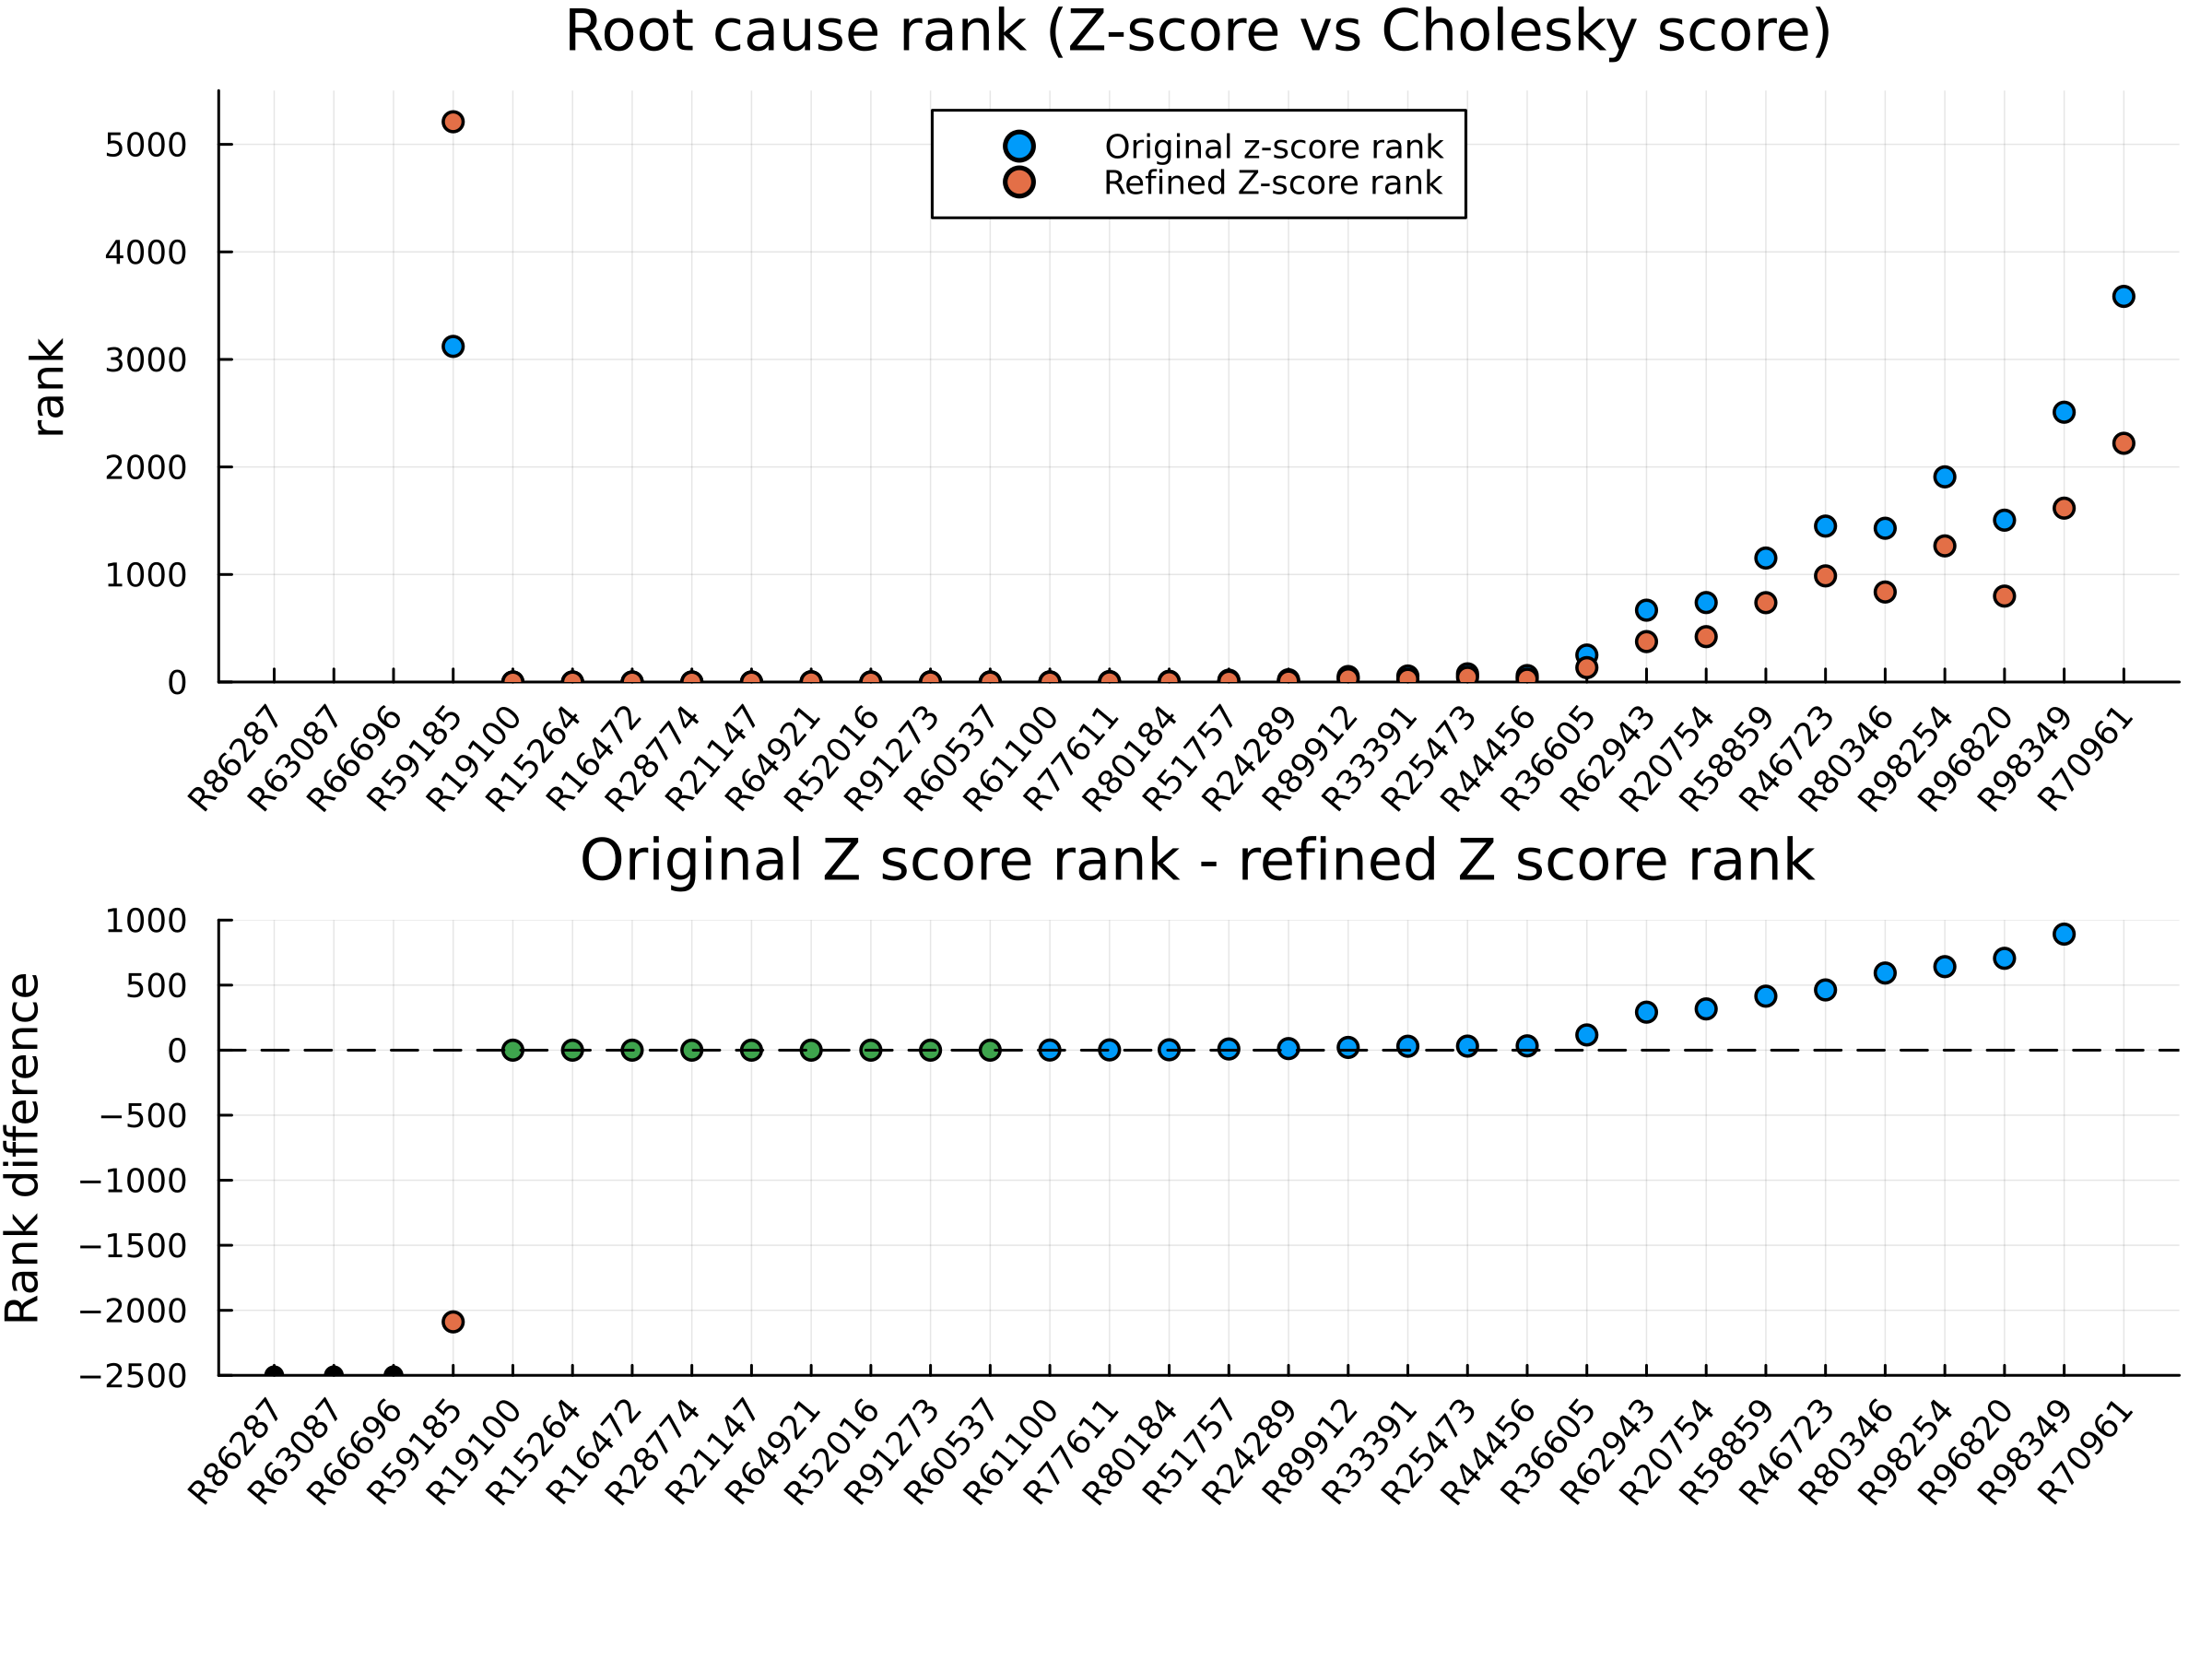

In [11]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2500, plot2_ymax = 1000
)
plot(plt)